In [27]:
import numpy as np
import pandas as pd

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_samples = 2000  # Number of samples

# Random temperature values in Celsius
temperatures_celsius = np.random.uniform(34.4, 40.0, size=num_samples)

# Assign categories based on temperature ranges in Celsius
categories = []
for temp in temperatures_celsius:
    if 36.5 <= temp <= 37.5:
        categories.append(0)  # Normal
    elif temp < 36.5:
        categories.append(1)  # Low Fever
    else:
        categories.append(2)  # High Fever

# Create a DataFrame
data = pd.DataFrame({'Temperature (°C)': temperatures_celsius, 'Category': categories})

# Save the dataset to a CSV file
data.to_csv('temperature_dataset.csv', index=False)

print("Dataset saved to 'temperature_dataset.csv'")


Dataset saved to 'temperature_dataset.csv'


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 2: Load dataset
data = pd.read_csv('temperature_dataset.csv')

# Preprocess the data
temperatures_celsius = data['Temperature (°C)'].values
categories = data['Category'].values

# Generate synthetic images based on temperatures
X = np.array([np.full((128, 128, 1), temp / 40.0) for temp in temperatures_celsius])  # Normalize by 40
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loaded and preprocessed.")


Data loaded and preprocessed.


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.5692 - loss: 0.9620 - val_accuracy: 0.8050 - val_loss: 0.7162
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8444 - loss: 0.6368 - val_accuracy: 0.8050 - val_loss: 0.5583
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8499 - loss: 0.5043 - val_accuracy: 0.8325 - val_loss: 0.4635
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8519 - loss: 0.4205 - val_accuracy: 0.8050 - val_loss: 0.4203
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.8581 - loss: 0.3823 - val_accuracy: 0.8450 - val_loss: 0.3680
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8567 - loss: 0.3462 - val_accuracy: 0.8850 - val_loss: 0.3365
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8996 - loss: 0.3101 - val_accuracy: 0.8525 - val_loss: 0.3160
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9306 - loss: 0.2905 - val_accuracy: 0.9200 - 

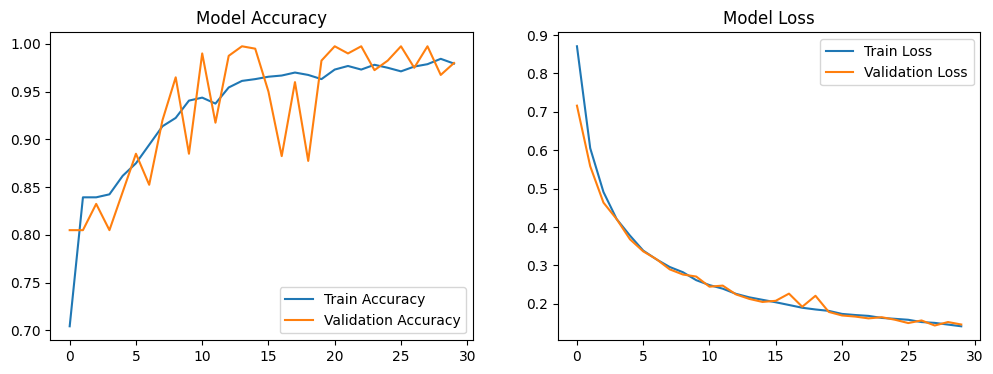

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# Step 3: Build the MobileNetV2 model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')  # 3 classes: Normal, Low Fever, High Fever
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,  # Adjust epochs based on training needs
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('temperature_model_mobilenet.h5')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


In [30]:
import numpy as np

# Step 5: Load the trained model
model = tf.keras.models.load_model('temperature_model_mobilenet.h5')

# Function to predict temperature category
def predict_temperature_category(temp_celsius):
    # Normalize the input temperature
    temp_normalized = temp_celsius / 40.0  # Normalize based on dataset range

    # Generate a dummy image
    X_input = np.full((128, 128, 1), temp_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Predict the category
    predictions = model.predict(X_input_resized)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class to its label
    class_labels = ['Normal', 'Low Fever', 'High Fever']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Test predictions
temps_to_test = [35.0, 36.5, 38.0, 39.5]
for temp in temps_to_test:
    predicted_label, probabilities = predict_temperature_category(temp)
    print(f"Temperature: {temp}°C -> Predicted: {predicted_label} (Probabilities: {probabilities})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
Temperature: 35.0°C -> Predicted: Low Fever (Probabilities: [[8.5115638e-03 9.9134278e-01 1.4568528e-04]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Temperature: 36.5°C -> Predicted: Normal (Probabilities: [[0.5137612  0.4653896  0.02084914]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Temperature: 38.0°C -> Predicted: High Fever (Probabilities: [[0.12536527 0.0035017  0.87113297]])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Temperature: 39.5°C -> Predicted: High Fever (Probabilities: [[5.0935335e-04 4.2311362e-06 9.9948633e-01]])


In [33]:
import tensorflow as tf
import numpy as np

# Step 5: Load the trained model
model = tf.keras.models.load_model('temperature_model_mobilenet.h5')

# Function to predict temperature category
def predict_temperature_category(temp_celsius):
    # Normalize the input temperature
    temp_normalized = temp_celsius / 40.0  # Normalize based on dataset range

    # Generate a dummy image
    X_input = np.full((128, 128, 1), temp_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Predict the category
    predictions = model.predict(X_input_resized)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class to its label
    class_labels = ['Normal', 'Low Fever', 'High Fever']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Input temperature value
temp_celsius = float(input("Enter a temperature in °C: "))
predicted_label, probabilities = predict_temperature_category(temp_celsius)
print(f"Temperature: {temp_celsius}°C -> Predicted: {predicted_label} (Probabilities: {probabilities})")


Enter a temperature in °C:  36.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Temperature: 36.5°C -> Predicted: Normal (Probabilities: [[0.5137612  0.4653896  0.02084914]])


In [4]:
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Low Fever', 'High Fever'])

# Plot Confusion Matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_pred_classes' is not defined

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Low Fever', 'High Fever'])

# Plot Confusion Matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_pred_classes' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


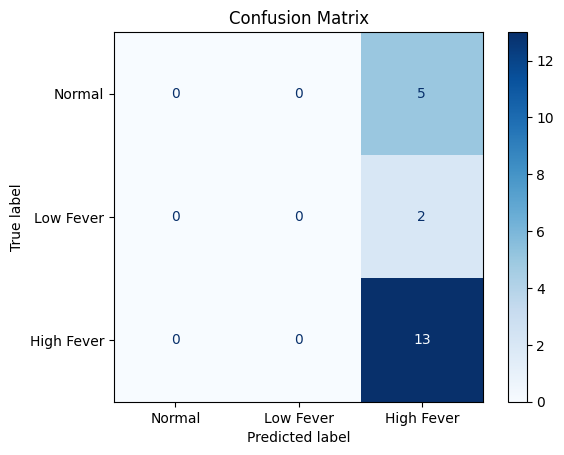

In [6]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert predictions to class labels

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 3: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Low Fever', 'High Fever'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert predictions to class labels

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 3: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Low Fever', 'High Fever'],
            yticklabels=['Normal', 'Low Fever', 'High Fever'])

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


ModuleNotFoundError: No module named 'seaborn'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


C:\Users\eshwa\AppData\Local\Temp\ipykernel_27388\2234892243.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
C:\Users\eshwa\AppData\Local\Temp\ipykernel_27388\2234892243.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])


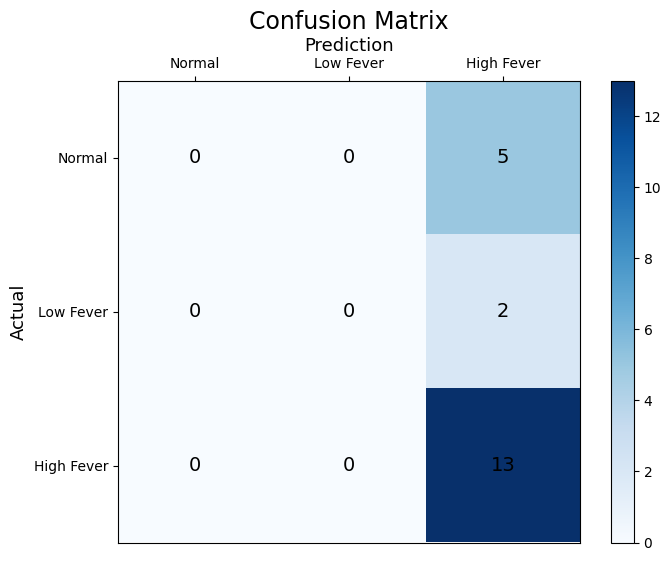

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert predictions to class labels

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 3: Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set labels
ax.set_xticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
ax.set_yticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
ax.set_xlabel('Prediction', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.gca().xaxis.tick_top()  # Move tick labels to the top
plt.show()


In [9]:
print(f"Predicted classes: {y_pred_classes[:20]}")
print(f"True classes: {y_test[:20]}")


Predicted classes: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
True classes: [0 2 2 2 1 2 1 2 0 0 2 2 0 2 0 2 2 2 2 2]


In [10]:
print("Class distribution in y_test:", np.bincount(y_test))


Class distribution in y_test: [ 5  2 13]


C:\Users\eshwa\AppData\Local\Temp\ipykernel_27388\1137856622.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
C:\Users\eshwa\AppData\Local\Temp\ipykernel_27388\1137856622.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])


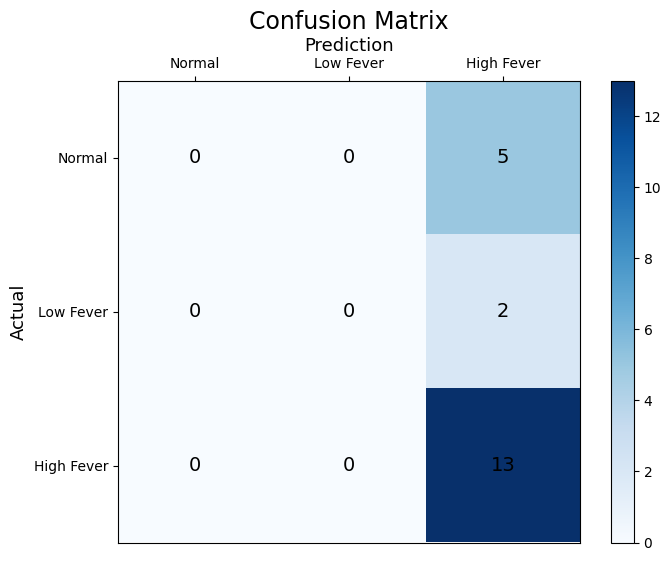

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set labels
ax.set_xticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
ax.set_yticklabels([''] + ['Normal', 'Low Fever', 'High Fever'])
ax.set_xlabel('Prediction', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.gca().xaxis.tick_top()  # Move tick labels to the top
plt.show()
